# 3D printing pluto dust

In [ ]:
from pathlib import Path
import sys
import imageio

import numpy as np

from scipy.interpolate import RegularGridInterpolator

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap

from IPython.display import display

from tqdm.auto import tqdm

import seaborn as sns

import astro3d
from astro3d.image_stack import makeslice
from astro3d.image_stack import makeslice_color
from astro3d.image_stack import VeroC_sRGB
from astro3d.image_stack import VeroM_sRGB
from astro3d.image_stack import VeroT_sRGB
from astro3d.image_stack import VeroY_sRGB

plt.style.use([{'image.cmap':'gray_r'}])

# Setup

## Read data

In [ ]:
with np.load('../../../data/pluto_data_norm.npz') as f:
    data = f['rho']
    x = f['x']
    y = f['y']
    z = f['z']

## Printer settings

printer specific and layer thickness can be chosen to be different)

In [ ]:
# these are the values for the J850 Prime
#dpi_x = 600
#dpi_y = 600
#dpi_z = 940  # 0.027 mm layer thickness

# these are the values used in alphacams TEILEFABRIK, where we ordered some of our prints
dpi_x = 600
dpi_y = 300
dpi_z = 940 # 0.027 mm layer thickness = 2.54 / dpi_z

Choose the height of the print, the rest should rescale accordingly

In [ ]:
height = 2 # this should be the total height of the printed cube in cm

## Output folder

We store the images in the path set by `output_dir`.

In [ ]:
output_dir = 'slices_pluto_color2'

In [ ]:
path = Path(output_dir)

if not path.is_dir():
    path.mkdir()
else:
    files = list(path.glob('slice*.png'))
    if len(files)>0:
        print('directory exists, deleting old files')
        for file in files:
            file.unlink()

## New coordinates

calculate the new grids in x, y, z

In [ ]:
#n_z = int(height / layer_thickness)
n_z = int(height * dpi_z / 2.54)

n_x = int(n_z * len(x) / len(z) / dpi_z * dpi_x)
n_y = int(n_z * len(y) / len(z) / dpi_z * dpi_y)

n_x += n_x%2 # add 1 to make it even if it isn't
n_y += n_y%2 # add 1 to make it even if it isn't

x2 = np.linspace(x[0], x[-1], n_x)
y2 = np.linspace(y[0], y[-1], n_y)
z2 = np.linspace(z[0], z[-1], n_z)

create an interpolation function for the non-normalized 3D data

In [ ]:
def f_interp(coords):
    return astro3d._fortran.fmodule.interpolate(x, y, z, data, coords)

set the coordinates-tuple which is passed to the interpolation. x and y entries will stay the same and only the z entry will change.

Note that `coords` will not be passed to the interpolation function in this form, but will be transformed to a shape `(N, 3)`, where the number of points `N = len(x2) * len(y2)`.

In [ ]:
coords = (x2, y2, z2)

## Normalization & color choices

Find the largest magnitude of the data values and define a logarithmic norm

In [ ]:
dyn_range = 1e-4
vmax = data.max()
norm = LogNorm(dyn_range * vmax, vmax, clip=True)

define the density levels, their width, their colors, and the filling factors of the colors

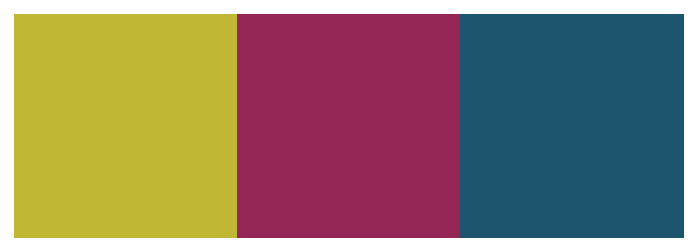

In [20]:
levels = np.array([0.15, 0.65, 0.92])
sigmas = np.array([0.02, 0.05, 0.06])
fill = np.array([0.1, 0.03, 0.1])
clip = np.array([3.0, 3.0, 3.0])

colors = [VeroY_sRGB, VeroM_sRGB, VeroC_sRGB]

plt.imshow([colors]).axes.axis('off');

Show a histogram of the data values

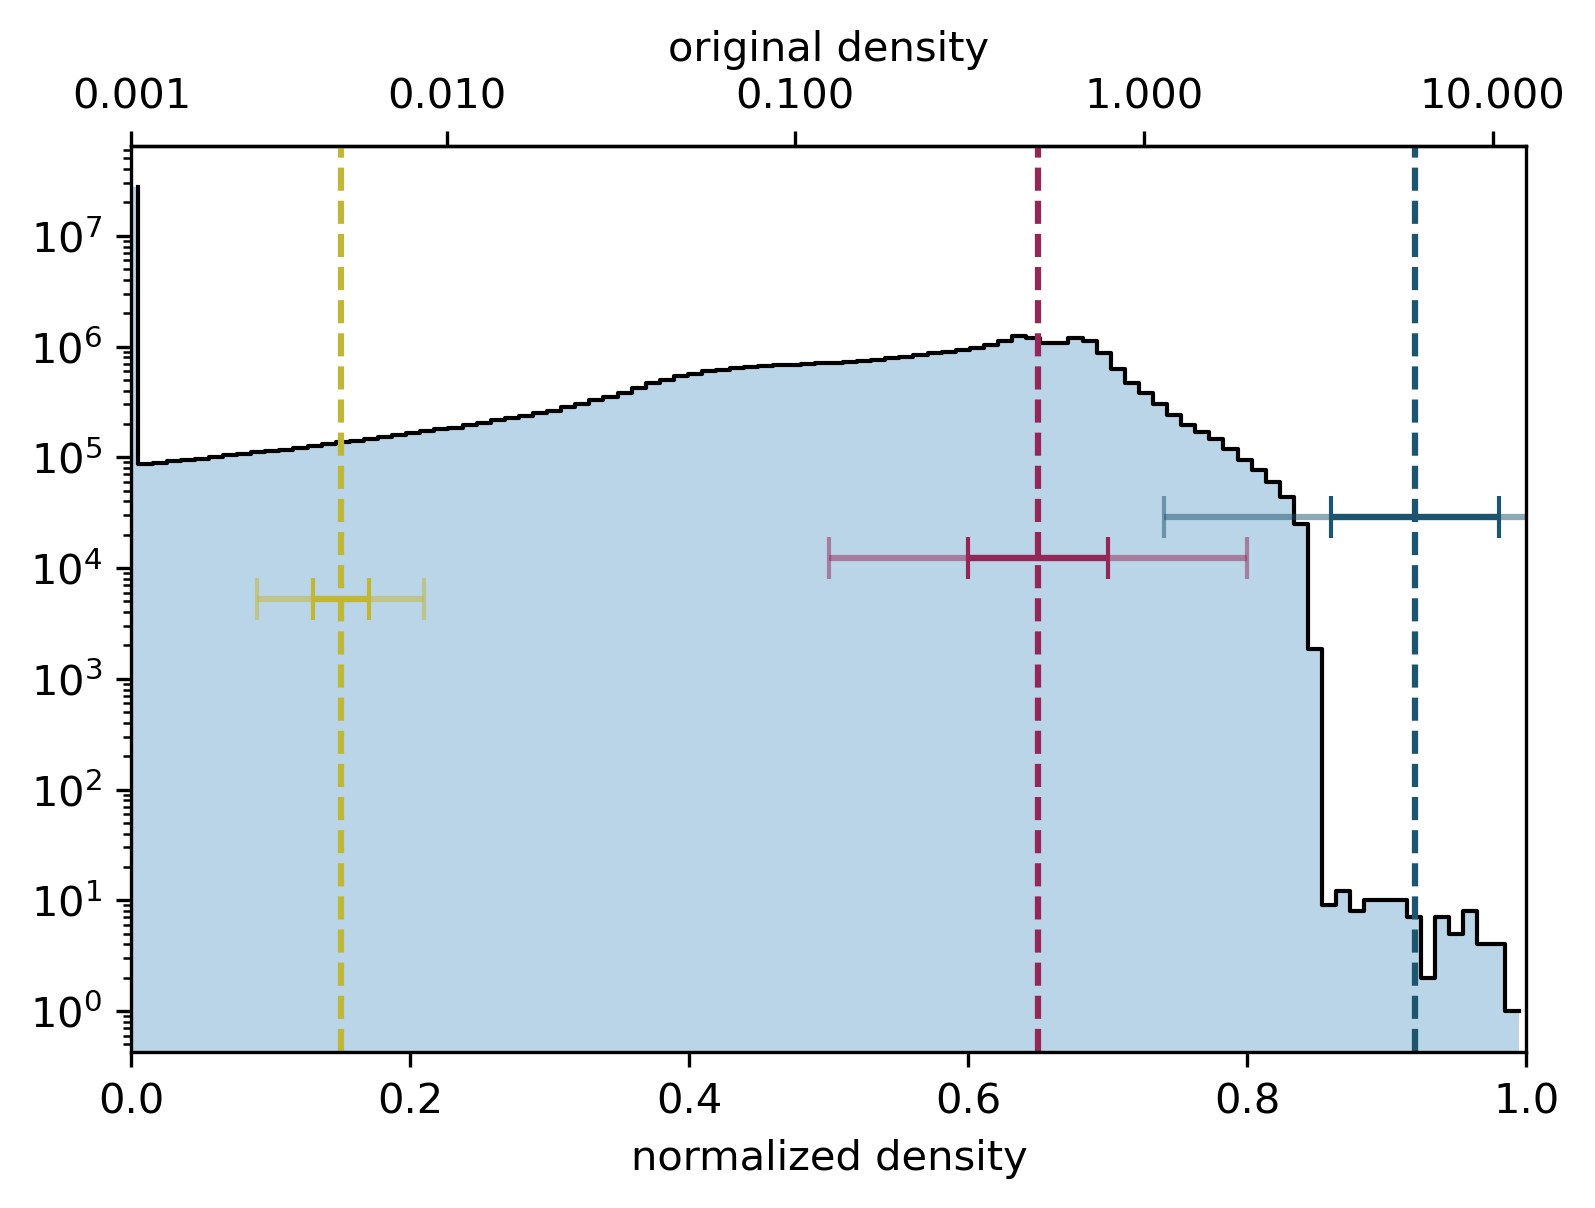

In [21]:
astro3d.image_stack.show_histogram(data, norm, colors, levels, sigmas, clip)

## Example slice

select which index in the new z-grid to process

In [26]:
iz = int(np.ceil(n_z / 2))

Process one slice and check the results

In [27]:
makeslice_color(iz, z2, f_interp, coords, norm, path,
                levels=levels, sigmas=sigmas, fill=fill,
                colors=colors, f=np.ones(3))

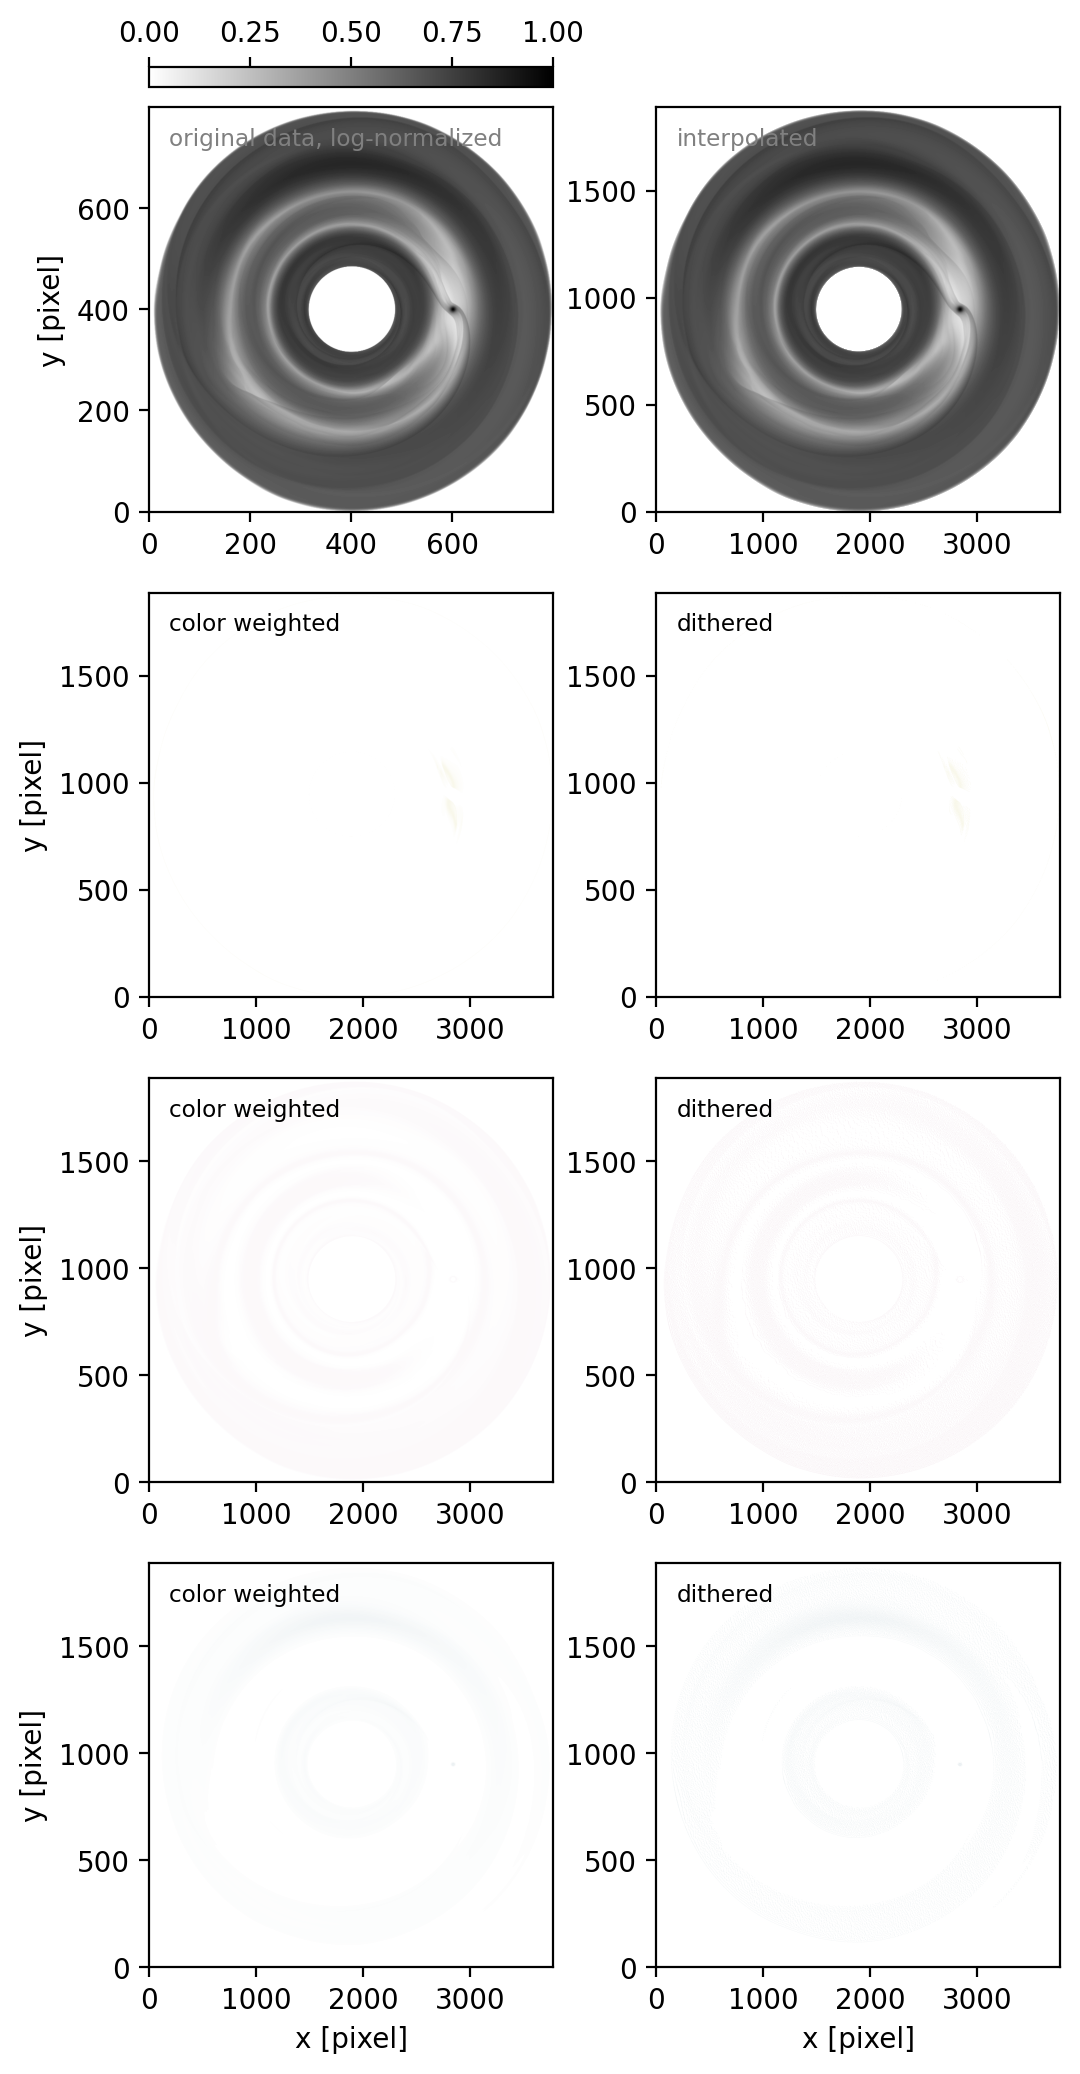

In [28]:
f, axs = plt.subplots(len(colors) + 1, 2, dpi=100, figsize=(6, 3 * (len(colors) + 1)), gridspec_kw={'top':0.9})
f.subplots_adjust(top=0.9)

# get original data near the desired position
iz0 = z.searchsorted(z2[iz])

cc=axs[0,0].imshow(norm(data[:,:,iz0]).T, vmin=0, vmax=1, origin='lower')
axs[0,0].text(0.05, 0.95, 'original data, log-normalized', c='0.5', fontsize='small', transform=axs[0,0].transAxes, va='top')

pos = axs[0,0].get_position()
cba = f.add_axes([pos.x0, pos.y1 + pos.height / 20, pos.width, pos.height / 20])
cb = f.colorbar(cc, cax=cba, orientation='horizontal')
cba.xaxis.tick_top()


# interpolate on new coordinates
_x, _y = np.meshgrid(x2, y2, indexing='ij')
_c = np.array([_x.ravel(), _y.ravel(), np.zeros_like(_x.ravel()) + z2[iz]]).T
d = f_interp(_c).reshape(len(x2), len(y2)).T

axs[0,1].imshow(d, origin='lower', norm=norm)
axs[0,1].text(0.05, 0.95, 'interpolated', fontsize='small', c='0.5', transform=axs[0,1].transAxes, va='top')

# color weightening
dist_sq = (norm(d.ravel()).reshape(d.shape)[..., None] - levels[None,None,:])**2 / (2 * sigmas[None, None, :]**2)
dist_sq[d==0] = np.inf
dist_sq[dist_sq  >clip**2] = np.inf
col_dens = 1. / (1. + dist_sq) * fill

# dithering
d2 = astro3d.fmodule.dither_colors(col_dens)


for ic, col in enumerate(colors):
    
    # cmap = sns.light_palette(col, as_cmap=True)
    cmap = LinearSegmentedColormap.from_list('my', [[1,1,1], col])
    
    axs[1+ic,0].imshow(col_dens[:, :, ic], origin='lower', vmin=0, vmax=1, cmap=cmap)
    axs[1+ic,0].text(0.05, 0.95, 'color weighted', fontsize='small', transform=axs[1+ic,0].transAxes, va='top')

    axs[1+ic,1].imshow(d2[:, :, ic], origin='lower', vmin=0, vmax=1, cmap=cmap)
    axs[1+ic,1].text(0.05, 0.95, 'dithered', fontsize='small', transform=axs[1+ic,1].transAxes, va='top');

# plot tunining


for ax in axs[:,0].ravel():
    ax.set_ylabel('y [pixel]');
for ax in axs[-1,:].ravel():
    ax.set_xlabel('x [pixel]');
    
for ax in axs.ravel()[1:]:
    ax.set_aspect(dpi_x / dpi_y)

# Iteration

In [29]:
# iz = np.arange(int(dpi_z/2.54))  # Here we just want to print the first cm
iz = np.arange(n_z)

In [30]:
for _iz in tqdm(iz):
    makeslice_color(_iz, z2, f_interp, coords, norm, path,
                    levels=levels, sigmas=sigmas, fill=fill,
                    colors=colors, f=np.ones(3))

  0%|          | 0/740 [00:00<?, ?it/s]